In [3]:
import pandas as pd
import numpy as np

# Load engineered dataset
df = pd.read_csv("../data/retail_features.csv")

# Convert date column
df['date'] = pd.to_datetime(df['date'])

# Sort correctly
df = df.sort_values(['sku_id', 'date']).copy()

print(df.shape)
df.head()

(35050, 18)


,date,sku_id,category,price,promotion,holiday,demand,day_of_week,month,quarter,day_of_year,week_of_year,lag_1,lag_7,lag_14,lag_30,rolling_mean_7,rolling_mean_30
0,2024-01-31,SKU_1,Sports,32.44,1,0,94,2,1,1,31,5,54.0,72.0,52.0,91.0,63.571429,61.733333
1,2024-02-01,SKU_1,Sports,16.93,0,0,64,3,2,1,32,5,94.0,64.0,55.0,43.0,66.714286,61.833333
2,2024-02-02,SKU_1,Sports,24.51,0,0,69,4,2,1,33,5,64.0,63.0,55.0,47.0,66.714286,62.533333
3,2024-02-03,SKU_1,Sports,26.79,0,0,75,5,2,1,34,5,69.0,61.0,50.0,66.0,67.571429,63.266667
4,2024-02-04,SKU_1,Sports,58.54,0,0,61,6,2,1,35,5,75.0,73.0,78.0,45.0,69.571429,63.566667


In [4]:
from xgboost import XGBRegressor

feature_cols = [
    'price',
    'promotion',
    'lag_7',
    'lag_14',
    'rolling_mean_7',
    'rolling_mean_30',
    'day_of_week',
    'month'
]

target = 'demand'

# Time split
split_date = df['date'].max() - pd.Timedelta(days=90)

train = df[df['date'] <= split_date].copy()

X_train = train[feature_cols]
y_train = train[target]

xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

xgb.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [5]:
sample = df[df['sku_id'] == df['sku_id'].unique()[0]].tail(1)

xgb.predict(sample[feature_cols])

array([113.55177], dtype=float32)

In [6]:
FORECAST_DAYS = 30


In [7]:
def recursive_forecast(model, df_sku, feature_cols, forecast_days=30):
    
    df_sku = df_sku.sort_values('date').copy()
    predictions = []
    
    for _ in range(forecast_days):
        
        last_row = df_sku.iloc[-1:].copy()
        last_date = last_row['date'].values[0]
        next_date = pd.to_datetime(last_date) + pd.Timedelta(days=1)
        
        # Update calendar features
        last_row['date'] = next_date
        last_row['day_of_week'] = next_date.dayofweek
        last_row['month'] = next_date.month
        
        # Update lag features dynamically
        last_row['lag_7'] = df_sku['demand'].iloc[-7]
        last_row['lag_14'] = df_sku['demand'].iloc[-14]
        
        # Update rolling features
        last_row['rolling_mean_7'] = df_sku['demand'].tail(7).mean()
        last_row['rolling_mean_30'] = df_sku['demand'].tail(30).mean()
        
        # Predict next demand
        X_input = last_row[feature_cols]
        pred = model.predict(X_input)[0]
        
        # Store prediction
        predictions.append({
            'date': next_date,
            'predicted_demand': pred
        })
        
        # Append prediction to df_sku for next iteration
        new_row = last_row.copy()
        new_row['demand'] = pred
        
        df_sku = pd.concat([df_sku, new_row], ignore_index=True)
    
    return pd.DataFrame(predictions)

In [8]:
all_forecasts = []

for sku in df['sku_id'].unique():
    
    df_sku = df[df['sku_id'] == sku].copy()
    
    future_df = recursive_forecast(
        model=xgb,
        df_sku=df_sku,
        feature_cols=feature_cols,
        forecast_days=FORECAST_DAYS
    )
    
    future_df['sku_id'] = sku
    all_forecasts.append(future_df)

future_forecast = pd.concat(all_forecasts, ignore_index=True)

print(future_forecast.head())

        date  predicted_demand sku_id
0 2026-01-01         92.512718  SKU_1
1 2026-01-02         79.873009  SKU_1
2 2026-01-03         90.504456  SKU_1
3 2026-01-04         87.292877  SKU_1
4 2026-01-05         81.311661  SKU_1


In [9]:
future_forecast.to_csv("../data/future_forecast.csv", index=False)

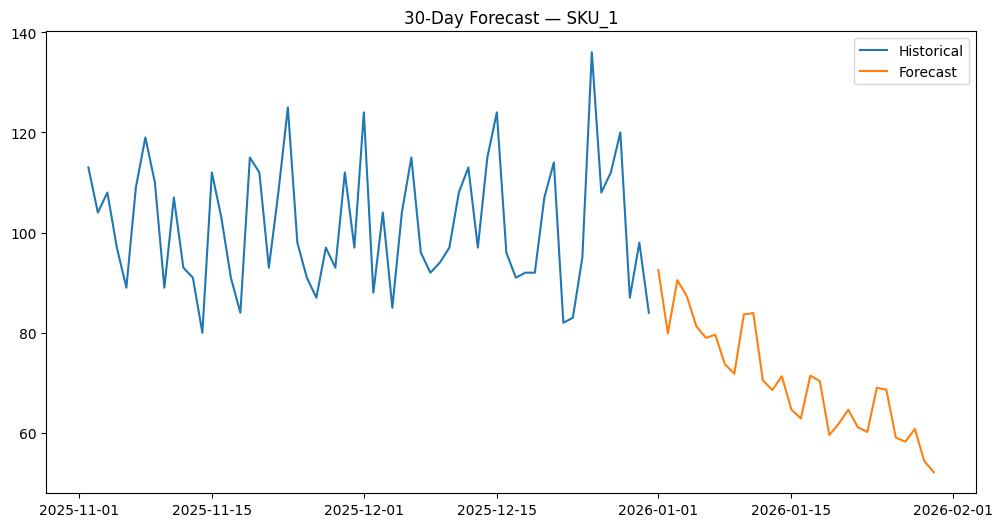

In [10]:
sample_sku = df['sku_id'].unique()[0]

historical = df[df['sku_id'] == sample_sku].tail(60)
forecast = future_forecast[future_forecast['sku_id'] == sample_sku]

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(historical['date'], historical['demand'], label='Historical')
plt.plot(forecast['date'], forecast['predicted_demand'], label='Forecast')
plt.legend()
plt.title(f"30-Day Forecast — {sample_sku}")
plt.show()

In [11]:
future_forecast['predicted_demand'].describe()

count    1500.000000
mean       59.735748
std        29.331581
min        -4.299941
25%        37.727073
50%        62.823828
75%        81.616564
max       137.654129
Name: predicted_demand, dtype: float64

In [12]:
future_forecast['predicted_demand'] = future_forecast['predicted_demand'].clip(lower=0)


In [13]:
daily_eval = test.groupby('date').agg({
    'demand': 'sum',
    'prediction': 'sum'
}).reset_index()

daily_eval = daily_eval.sort_values('date')
daily_eval.head()

NameError: name 'test' is not defined

In [14]:
# Time-based split (last 90 days as test)
split_date = df['date'].max() - pd.Timedelta(days=90)

train = df[df['date'] <= split_date].copy()
test = df[df['date'] > split_date].copy()

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (30550, 18)
Test shape: (4500, 18)


In [15]:
feature_cols = [
    'price',
    'promotion',
    'lag_7',
    'lag_14',
    'rolling_mean_7',
    'rolling_mean_30',
    'day_of_week',
    'month'
]

target = 'demand'

In [16]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

xgb.fit(train[feature_cols], train[target])

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [17]:
test['prediction'] = xgb.predict(test[feature_cols])

In [18]:
test[['date','demand','prediction']].head()

,date,demand,prediction
611,2025-10-03,94,92.092041
612,2025-10-04,89,87.730865
613,2025-10-05,99,90.710419
614,2025-10-06,73,69.765572
615,2025-10-07,67,64.401817


In [19]:
daily_eval = test.groupby('date').agg({
    'demand': 'sum',
    'prediction': 'sum'
}).reset_index()

daily_eval = daily_eval.sort_values('date')

daily_eval.head()

,date,demand,prediction
0,2025-10-03,2973,2936.234619
1,2025-10-04,3173,3183.245850
2,2025-10-05,3308,3368.633301
3,2025-10-06,2838,2891.704590
4,2025-10-07,2693,2695.442383


In [20]:
horizons = [7, 14, 30]
horizon_results = []

for h in horizons:
    
    subset = daily_eval.head(h)
    
    mae, rmse, mape = evaluate(
        subset['demand'],
        subset['prediction']
    )
    
    horizon_results.append({
        'Horizon_Days': h,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    })

horizon_results = pd.DataFrame(horizon_results)

print(horizon_results)

NameError: name 'evaluate' is not defined

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Safe MAPE (avoid division by zero)
    mape = np.mean(
        np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))
    ) * 100
    
    return mae, rmse, mape
    

In [22]:
horizons = [7, 14, 30]
horizon_results = []

for h in horizons:
    
    subset = daily_eval.head(h)
    
    mae, rmse, mape = evaluate(
        subset['demand'],
        subset['prediction']
    )
    
    horizon_results.append({
        'Horizon_Days': h,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    })

horizon_results = pd.DataFrame(horizon_results)

print(horizon_results)

   Horizon_Days        MAE        RMSE      MAPE
0             7  29.390207   36.581337  0.990517
1            14  25.202549   32.888925  0.859519
2            30  48.139404  103.684891  1.462767


In [23]:
daily_eval = test.groupby('date').agg({
    'demand': 'sum',
    'prediction': 'sum'
}).reset_index()

daily_eval = daily_eval.sort_values('date')

daily_eval.head()

,date,demand,prediction
0,2025-10-03,2973,2936.234619
1,2025-10-04,3173,3183.245850
2,2025-10-05,3308,3368.633301
3,2025-10-06,2838,2891.704590
4,2025-10-07,2693,2695.442383


In [24]:
horizons = [7, 14, 30]
horizon_results = []

for h in horizons:
    
    subset = daily_eval.head(h)
    
    mae, rmse, mape = evaluate(
        subset['demand'],
        subset['prediction']
    )
    
    horizon_results.append({
        'Horizon_Days': h,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    })

horizon_results = pd.DataFrame(horizon_results)

print(horizon_results)

   Horizon_Days        MAE        RMSE      MAPE
0             7  29.390207   36.581337  0.990517
1            14  25.202549   32.888925  0.859519
2            30  48.139404  103.684891  1.462767


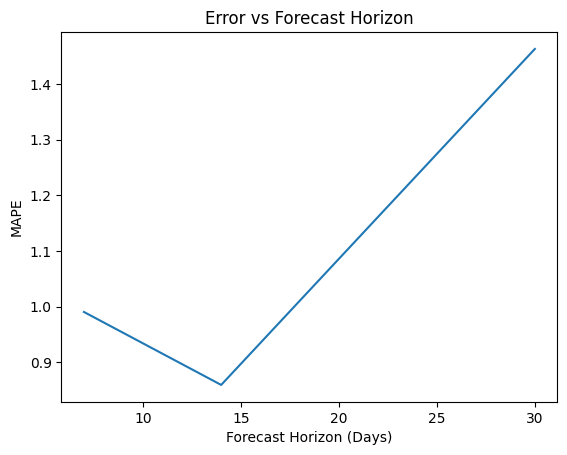

In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(horizon_results['Horizon_Days'],
         horizon_results['MAPE'])

plt.xlabel("Forecast Horizon (Days)")
plt.ylabel("MAPE")
plt.title("Error vs Forecast Horizon")
plt.savefig("../reports/figures/horizon_performance.png")
plt.show()